# Analysis of the rent dataset

## Overview

Before we start analyzing the data and explaining our intentions, we need to get an overview of the existing data. No matter what we later want to do, we have to clean and prepocess our data in order to work with it 

### Load data

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_object_dtype
pd.set_option('display.max_columns', None)
%matplotlib inline

In [37]:
df = pd.read_csv("../data/testlizenz-tuebingen-dataliteracy4students_1700939273256.csv", sep=";", encoding='unicode_escape')
df.count() 

angebot_id                    16008
anz_parken                    10830
anz_zimmer                    15865
aus_alarmanlage_janein        16008
aus_bad_dusche_janein         16008
                              ...  
oeig_dachgeschoss_janein      16008
enddate                       15707
aus_balkon_terrasse_janein    16008
aus_wintergarten_janein       16008
aus_garten_eigen_janein       16008
Length: 87, dtype: int64

In [38]:
# include year column
df['year'] = df['startdate'].str[:4] 

In [39]:
df["month"] = pd.DatetimeIndex(df['startdate']).month

In [40]:
df

angebot_id  anz_parken anz_zimmer  aus_alarmanlage_janein  \
0      3594713336         NaN         2,                       0   
1      3594016393         NaN         2,                       0   
2      3593975043         NaN         1,                       0   
3      3594255459         1.0         3,                       0   
4      3594061704         1.0         3,                       0   
...           ...         ...        ...                     ...   
16003  3041045247         NaN        2,5                       0   
16004  3040210896         NaN         4,                       0   
16005  3058502400         NaN         7,                       0   
16006  3032926122         NaN         4,                       0   
16007  3043830326         NaN         7,                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
0                          1                        0   
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
...                      ...                      ...   
16003                      1                        0   
16004                      0                        1   
16005                      1                        0   
16006                      0                        0   
16007                      0                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
0                               0                     0   
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
...                           ...                   ...   
16003                           1                     1   
16004                           0                     1   
16005                           0                     0   
16006                           0                     1   
16007                           0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
...                         ...                        ...   
16003                         0                          0   
16004                         0                          0   
16005                         0                          0   
16006                         0                          0   
16007                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
...                           ...                        ...   
16003                           0                          0   
16004                           0                          0   
16005                           0                          1   
16006                           0                          0   
16007                           0                          1   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
0                            0                 NaN   
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4           

### How many houses and flats are in the dataset?

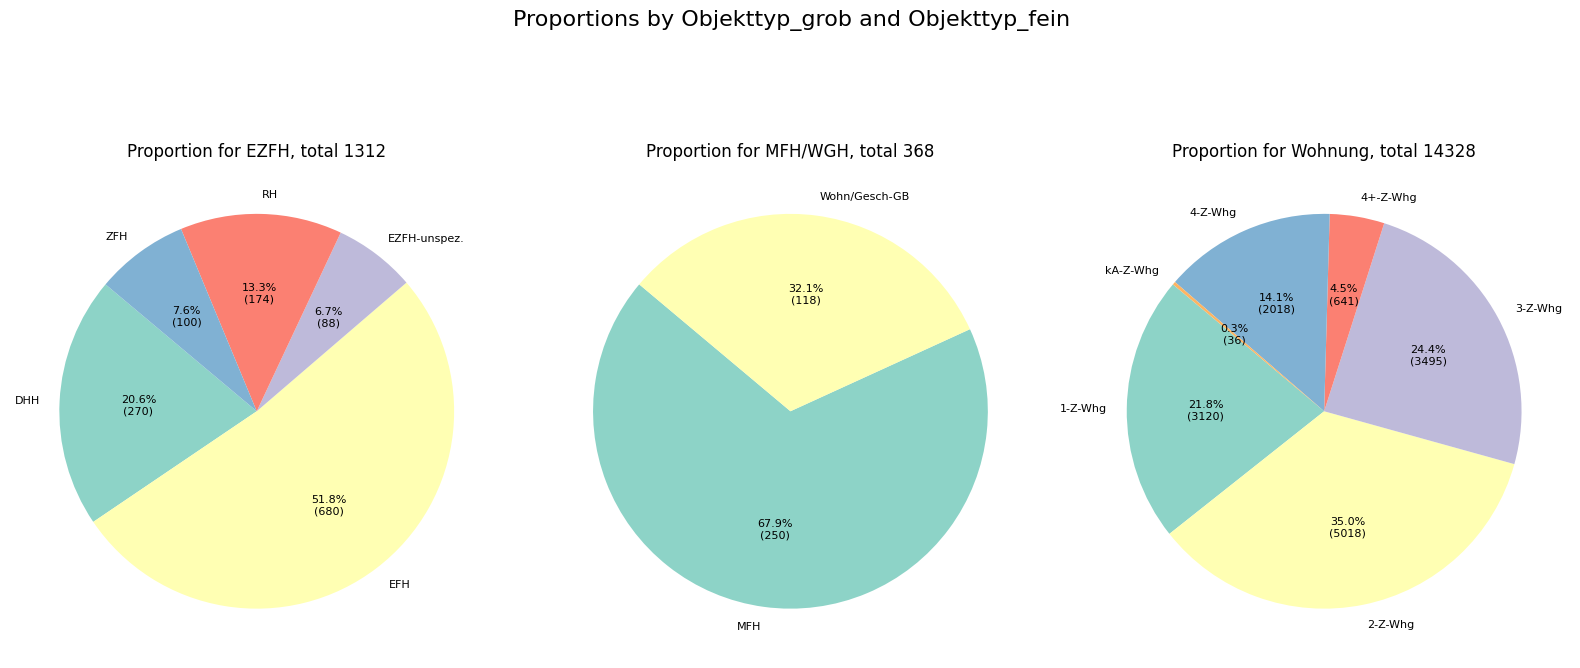

In [41]:
grouped_df = df.groupby(["objekttyp_grob", "objekttyp_fein"]).size().reset_index(name='count')
unique_grobs = grouped_df['objekttyp_grob'].unique()
fig, axes = plt.subplots(1, len(unique_grobs), figsize=(16, 8), subplot_kw=dict(aspect="equal"))
subtitle_text = ""
colors = plt.cm.Set3.colors  # Set color palette, adjust as needed

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"


for i, (grob, ax) in enumerate(zip(unique_grobs, axes.flatten())):
    grob_df = grouped_df[grouped_df['objekttyp_grob'] == grob]
    wedges, texts, autotexts = ax.pie(grob_df['count'], labels=grob_df['objekttyp_fein'], autopct=lambda pct: func(pct, grob_df['count']),
                                      colors=colors, startangle=140)
    ax.set_title(f'Proportion for {grob}, total {grob_df["count"].sum()}')
    
    # Increase the size of the labels and percentage values for better visibility
    for text in texts + autotexts:
        text.set_fontsize(8)
    # subtitle_text += f"Total for {grob}: {grob_df['count'].sum()} \n \n"
    
fig.suptitle(f'{subtitle_text}\n', fontsize=16, style='italic')
fig.suptitle('Proportions by Objekttyp_grob and Objekttyp_fein', fontsize=16)
fig.tight_layout()
plt.show()

#### We can clearly see that there are far more flats than houses.

### How many of those flats and houses are for sail, how many for rent?

In [42]:
df.groupby(["objekttyp_grob", "nachfrageart"]).size().reset_index(name='count')

objekttyp_grob nachfrageart  count
0           EZFH         kauf   1032
1           EZFH        miete    280
2        MFH/WGH         kauf    368
3        Wohnung         kauf   3754
4        Wohnung        miete  10574

-------------

# Where are those flats and houses located?
Now that we have generated a quick overview about our data, we will now focus on where these flats and houses actually are. We want to identify the region in Tübingen that has the most offers. Once we have categorized the data by region, we will also look at the price distribution in each region to compare the prices but simultaneously the regions.  

## Cleaning process..

*With which loaction do we start?*
Given are two different location attributes, *oadr_u2* being more specific than *oadr_u1*.

In [43]:
df_total_oadr_u1 = df.groupby(["oadr_u1"]).size().reset_index(name='count')
df_total_oadr_u1_count = df["oadr_u1"].isnull().sum()
print(f"Total number of OADR_U1: {df_total_oadr_u1['count'].sum()}")
print(f"Total number of OADR_U1 with no value: {df_total_oadr_u1_count}")
df.groupby(["oadr_u1"]).size().reset_index(name='count')

Total number of OADR_U1: 11927
Total number of OADR_U1 with no value: 4081


oadr_u1  count
0     Bebenhausen     63
1            Bühl    403
2     Derendingen    870
3       Hagelloch    182
4        Hirschau    472
5       Kilchberg    138
6         Lustnau   1456
7       Pfrondorf    420
8        Tübingen   7456
9   Unterjesingen    329
10       Weilheim    138

In [44]:
df_total_oadr_u2 = df.groupby(["oadr_u2"]).size().reset_index(name='count')
df_total_oadr_u2_count = df["oadr_u2"].isnull().sum()
print(f"Total number of OADR_U2: {df_total_oadr_u2['count'].sum()}")
print(f"Total number of OADR_U2 with no value: {df_total_oadr_u2_count}")
df.groupby(["oadr_u2"]).size().reset_index(name='count')

Total number of OADR_U2: 9131
Total number of OADR_U2 with no value: 6877


oadr_u2  count
0                                  Aeule     76
1   Au/Unterer Wert/Französiches Viertel    481
2                            Bebenhausen     63
3                                   Bühl    403
4                             De-Zentrum     90
5                        Denzenberg/Sand    191
6               Feuerhägle/Mühlenviertel    269
7                            Gartenstadt     26
8                              Hagelloch    182
9                               Hirschau    472
10                             Kilchberg    138
11  Lustnau-Zentrum/Herrlesberg/Stäudach    403
12                              Neuhalde    111
13                             Pfrondorf    420
14             Schönblick/Waldhäuser Ost    614
15                              Südstadt   1047
16                           Universität   1030
17                         Unterjesingen    329
18                                 Wanne    661
19                              Weilheim    138
20                             Weststadt   1053
21                               Zentrum    727
22                Österberg/Gartenstraße    207

In [45]:
df[df["oadr_u2"].isna()].groupby(["oadr_u1"]).size().reset_index(name='count')

oadr_u1  count
0  Derendingen    485
1      Lustnau    675
2     Tübingen   1636

In [46]:
df[df["oadr_u1"].isna()].groupby(["oadr_u2"]).size().reset_index(name='count')

Empty DataFrame
Columns: [oadr_u2, count]
Index: []

In [47]:
df.groupby(["oadr_u2", "oadr_u1"]).size().reset_index(name='count').sort_values(by=['oadr_u1'], ascending=False)

oadr_u2        oadr_u1  count
19                              Weilheim       Weilheim    138
17                         Unterjesingen  Unterjesingen    329
22                Österberg/Gartenstraße       Tübingen    207
21                               Zentrum       Tübingen    727
20                             Weststadt       Tübingen   1053
18                                 Wanne       Tübingen    661
16                           Universität       Tübingen   1030
15                              Südstadt       Tübingen   1047
14             Schönblick/Waldhäuser Ost       Tübingen    614
1   Au/Unterer Wert/Französiches Viertel       Tübingen    481
13                             Pfrondorf      Pfrondorf    420
12                              Neuhalde        Lustnau    111
0                                  Aeule        Lustnau     76
5                        Denzenberg/Sand        Lustnau    191
11  Lustnau-Zentrum/Herrlesberg/Stäudach        Lustnau    403
10                             Kilchberg      Kilchberg    138
9                               Hirschau       Hirschau    472
8                              Hagelloch      Hagelloch    182
7                            Gartenstadt    Derendingen     26
6               Feuerhägle/Mühlenviertel    Derendingen    269
4                             De-Zentrum    Derendingen     90
3                                   Bühl           Bühl    403
2                            Bebenhausen    Bebenhausen     63

In [48]:
oadr_u2 = df["oadr_u2"].unique().tolist()
cleaned_oadr_2 = [x for x in oadr_u2 if x == x]
cleaned_oadr_2

['Universität',
 'Schönblick/Waldhäuser Ost',
 'Zentrum',
 'Bühl',
 'Südstadt',
 'Hagelloch',
 'Kilchberg',
 'Au/Unterer Wert/Französiches Viertel',
 'Weststadt',
 'Bebenhausen',
 'Hirschau',
 'Österberg/Gartenstraße',
 'Pfrondorf',
 'Wanne',
 'Unterjesingen',
 'Feuerhägle/Mühlenviertel',
 'Lustnau-Zentrum/Herrlesberg/Stäudach',
 'De-Zentrum',
 'Aeule',
 'Weilheim',
 'Denzenberg/Sand',
 'Gartenstadt',
 'Neuhalde']

For the further approach, knowing where the houses are is important. Therefore we will now clean the data and remove all entries that do not have a location attribute.

In [49]:
df_w_loc = df[df['oadr_u1'].notna()]
df_wo_loc = df[df['oadr_u1'].isna()]
print(f"Total number of rows with location: {df_w_loc.shape[0]}")
print(f"Total number of rows without location: {df_wo_loc.shape[0]}")

Total number of rows with location: 11927
Total number of rows without location: 4081


### Adjusting entries
From previous analysis I know that the integer and float values in the dataset are kind of messy, pandas cant interpret them as actual values because they are seperated with **`,`** instead of **`.`** Lets fix this.

In [50]:
df_w_loc

angebot_id  anz_parken anz_zimmer  aus_alarmanlage_janein  \
1      3594016393         NaN         2,                       0   
2      3593975043         NaN         1,                       0   
3      3594255459         1.0         3,                       0   
4      3594061704         1.0         3,                       0   
5      3593974527         2.0        2,5                       0   
...           ...         ...        ...                     ...   
15998    27439257         1.0         5,                       0   
15999    27424499         1.0         2,                       0   
16001    27375419         1.0         6,                       0   
16002    27260230         1.0         6,                       0   
16004  3040210896         NaN         4,                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
5                          0                        0   
...                      ...                      ...   
15998                      1                        1   
15999                      1                        0   
16001                      1                        1   
16002                      1                        1   
16004                      0                        1   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
5                               0                     1   
...                           ...                   ...   
15998                           0                     1   
15999                           0                     1   
16001                           0                     0   
16002                           0                     0   
16004                           0                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
5                             0                          0   
...                         ...                        ...   
15998                         0                          0   
15999                         0                          0   
16001                         0                          0   
16002                         0                          0   
16004                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
5                               0                          0   
...                           ...                        ...   
15998                           0                          0   
15999                           0                          0   
16001                           0                          1   
16002                           0                          1   
16004                           0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4                            0                  Öl   
5           

In [51]:
df_w_loc["fl_wohnen"].dtype

dtype('O')

In [52]:
for column in df.columns:
    if is_object_dtype(df[column]):
        if df[column].str.contains(',').any(): 
            df[column] = df[column].str.replace(',', '.').astype(float)
            df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
df_w_loc

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_5366/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_5366/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_5366/1307623920.py:5: SettingWithCopyWarning: 
A value 

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
1      3594016393         NaN         2.0                       0   
2      3593975043         NaN         1.0                       0   
3      3594255459         1.0         3.0                       0   
4      3594061704         1.0         3.0                       0   
5      3593974527         2.0         2.5                       0   
...           ...         ...         ...                     ...   
15998    27439257         1.0         5.0                       0   
15999    27424499         1.0         2.0                       0   
16001    27375419         1.0         6.0                       0   
16002    27260230         1.0         6.0                       0   
16004  3040210896         NaN         4.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
5                          0                        0   
...                      ...                      ...   
15998                      1                        1   
15999                      1                        0   
16001                      1                        1   
16002                      1                        1   
16004                      0                        1   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
5                               0                     1   
...                           ...                   ...   
15998                           0                     1   
15999                           0                     1   
16001                           0                     0   
16002                           0                     0   
16004                           0                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
5                             0                          0   
...                         ...                        ...   
15998                         0                          0   
15999                         0                          0   
16001                         0                          0   
16002                         0                          0   
16004                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
5                               0                          0   
...                           ...                        ...   
15998                           0                          0   
15999                           0                          0   
16001                           0                          1   
16002                           0                          1   
16004                           0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4                            0                  Öl   


In [53]:
df_w_loc.shape[0]

11927

## Now that we have cleaned our data, lets look at the regions

In [54]:
df_w_loc.groupby(["oadr_u1"]).size().reset_index(name='count')

oadr_u1  count
0     Bebenhausen     63
1            Bühl    403
2     Derendingen    870
3       Hagelloch    182
4        Hirschau    472
5       Kilchberg    138
6         Lustnau   1456
7       Pfrondorf    420
8        Tübingen   7456
9   Unterjesingen    329
10       Weilheim    138

## Display them in a map
We are going to display a map of Tübingen where we will mark the locations of the flats and houses. The color of the marker will represent the price of the flat/house. The darker the marker, the higher the price. 

In [55]:
import geopandas as gpd

path_tue_shp = '../data/KLGL_Stadtteile_Shape/KLGL_Stadtteile_Shape.shp'
tuebingen_gdf = gpd.read_file('../data/KLGL_Stadtteile_Shape/KLGL_Stadtteile_Shape.shp')


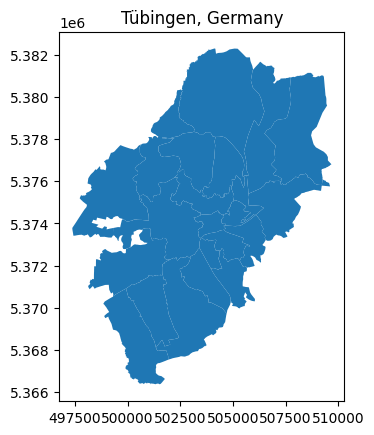

In [56]:
tuebingen_gdf.plot()
plt.title('Tübingen, Germany')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


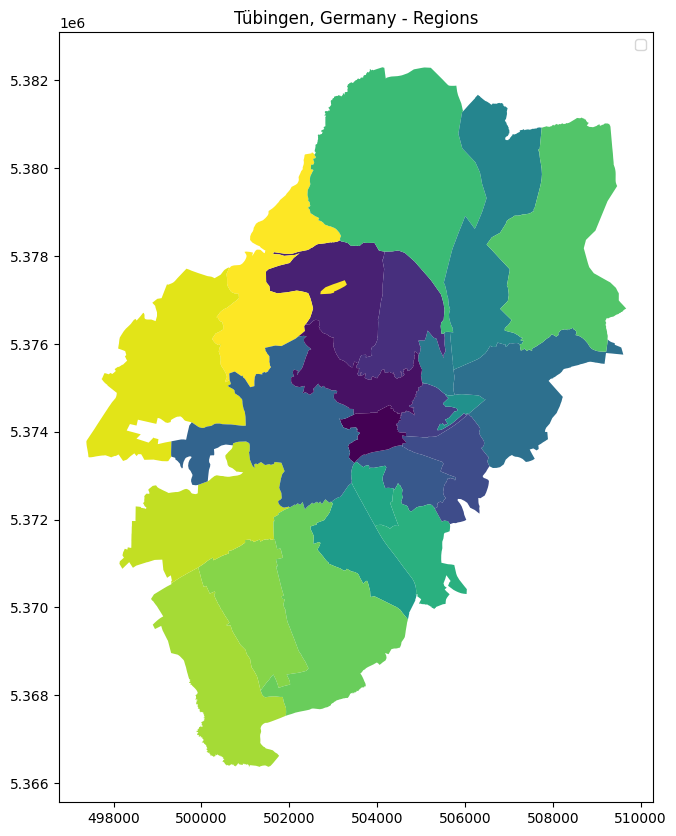

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf.plot(ax=ax, cmap='viridis', edgecolor=None, legend=True, column='STT')

# Add labels and legend
plt.title('Tübingen, Germany - Regions')
plt.legend()

# Show the plot
plt.show()


### Issue we faced
We have no labels in the polygons, which makes it hard to identify the regions

#### Solution: Assign random labels to see which polygon corresponds to which region

['m2', 'cq', 'cf', 'c7', '35', 'ds', 'q2', '1a', '3a', 'se', 'gz', 'oq', 'fz', 'ha', '8t', 'x1', '65', 'rk', 'ye', '11', '3r', 'cl', 'fs']


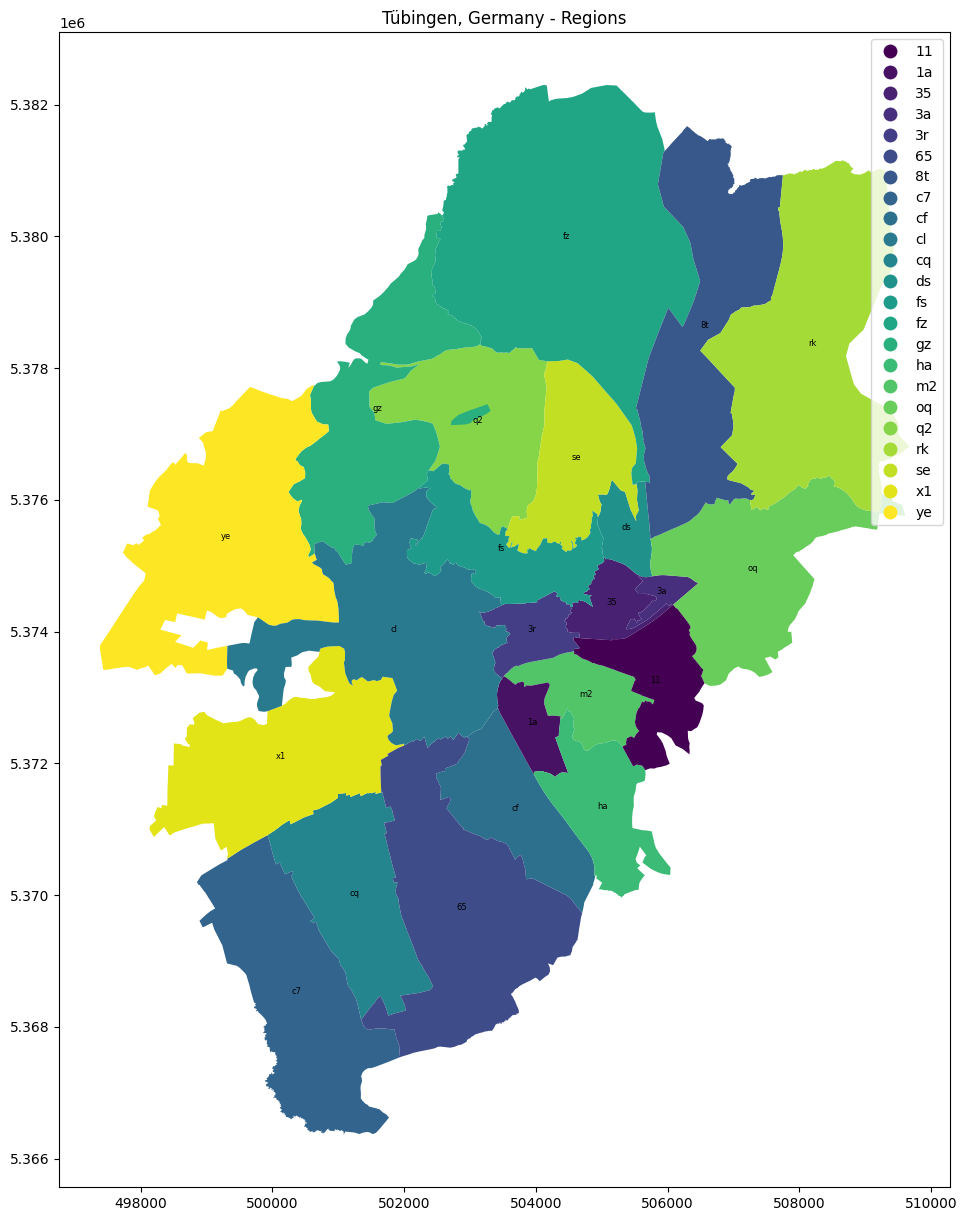

In [58]:
from random import choice
from string import ascii_lowercase, digits

chars = ascii_lowercase + digits
lst = [''.join(choice(chars) for _ in range(2)) for _ in range(23)]
print(lst)
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = lst
# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(20, 15))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf.plot(ax=ax, cmap='viridis', edgecolor=None, legend=True,  column="region",)
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions')

# Show the plot
plt.show()


## Map regions now with OADR-U2

In [59]:
shp_dict = {'Universität':22,
 'Schönblick/Waldhäuser Ost':9,
 'Zentrum':20,
 'Bühl': 3,
 'Südstadt': 0,
 'Hagelloch': 10,
 'Kilchberg': 1,
 'Au/Unterer Wert/Französiches Viertel':19,
 'Weststadt':21,
 'Bebenhausen':12,
 'Hirschau':15,
 'Österberg/Gartenstraße':4,
 'Pfrondorf':17,
 'Wanne': 6,
 'Unterjesingen':18,
 'Feuerhägle/Mühlenviertel':7,
 'Lustnau-Zentrum/Herrlesberg/Stäudach':11,
 'De-Zentrum': 2,
 'Aeule':8,
 'Weilheim':16,
 'Denzenberg/Sand': 5,
 'Gartenstadt':13,
 'Neuhalde':14 }
sorted_dict = dict(sorted(shp_dict.items(), key=lambda item: item[1]))
sorted_dict

{'Südstadt': 0,
 'Kilchberg': 1,
 'De-Zentrum': 2,
 'Bühl': 3,
 'Österberg/Gartenstraße': 4,
 'Denzenberg/Sand': 5,
 'Wanne': 6,
 'Feuerhägle/Mühlenviertel': 7,
 'Aeule': 8,
 'Schönblick/Waldhäuser Ost': 9,
 'Hagelloch': 10,
 'Lustnau-Zentrum/Herrlesberg/Stäudach': 11,
 'Bebenhausen': 12,
 'Gartenstadt': 13,
 'Neuhalde': 14,
 'Hirschau': 15,
 'Weilheim': 16,
 'Pfrondorf': 17,
 'Unterjesingen': 18,
 'Au/Unterer Wert/Französiches Viertel': 19,
 'Zentrum': 20,
 'Weststadt': 21,
 'Universität': 22}

In [60]:
res = dict((v,k) for k,v in shp_dict.items()) # just swaps the keys and values

In [61]:
df.groupby(['oadr_u1'])['oadr_u2'].apply(lambda grp: list(grp.value_counts().index)).to_dict() # could be useful maybe 

{'Bebenhausen': ['Bebenhausen'],
 'Bühl': ['Bühl'],
 'Derendingen': ['Feuerhägle/Mühlenviertel', 'De-Zentrum', 'Gartenstadt'],
 'Hagelloch': ['Hagelloch'],
 'Hirschau': ['Hirschau'],
 'Kilchberg': ['Kilchberg'],
 'Lustnau': ['Lustnau-Zentrum/Herrlesberg/Stäudach',
  'Denzenberg/Sand',
  'Neuhalde',
  'Aeule'],
 'Pfrondorf': ['Pfrondorf'],
 'Tübingen': ['Weststadt',
  'Südstadt',
  'Universität',
  'Zentrum',
  'Wanne',
  'Schönblick/Waldhäuser Ost',
  'Au/Unterer Wert/Französiches Viertel',
  'Österberg/Gartenstraße'],
 'Unterjesingen': ['Unterjesingen'],
 'Weilheim': ['Weilheim']}

### Plot the map with the right regions

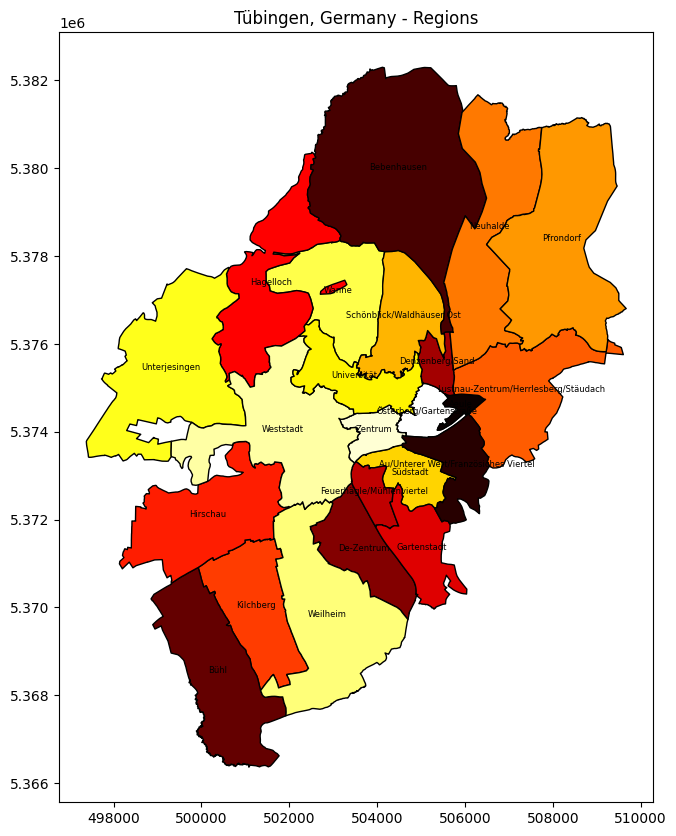

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = sorted_dict.keys()

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf.plot(ax=ax, cmap='hot', edgecolor='black', column="region",)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions')

# Show the plot
plt.show()


### Generate random column with value representing the density and plot it

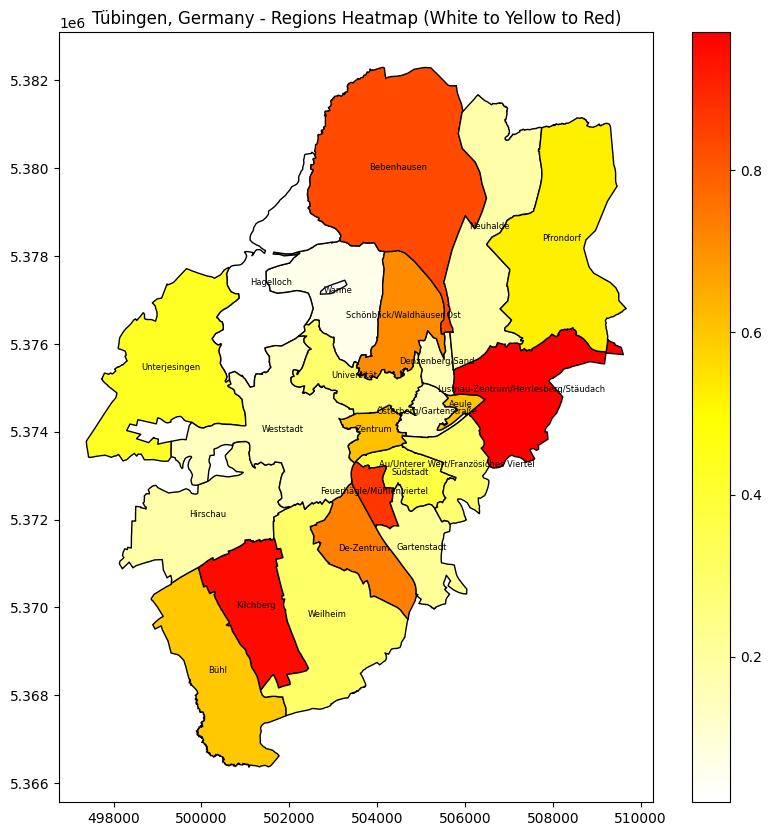

In [63]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)

# Assign random density values to each region for demonstration purposes
np.random.seed(42)  # Set a seed for reproducibility
tuebingen_gdf["density"] = np.random.rand(len(tuebingen_gdf))
tuebingen_gdf["region"] = sorted_dict.keys()
# Define a custom colormap from white to yellow to red
colors = [(1, 1, 1), (1, 1, 0), (1, 0, 0)]  # White to yellow to red
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="density", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

# Show the plot
plt.show()


# Density plot
## The more flats in one area, the darker the color

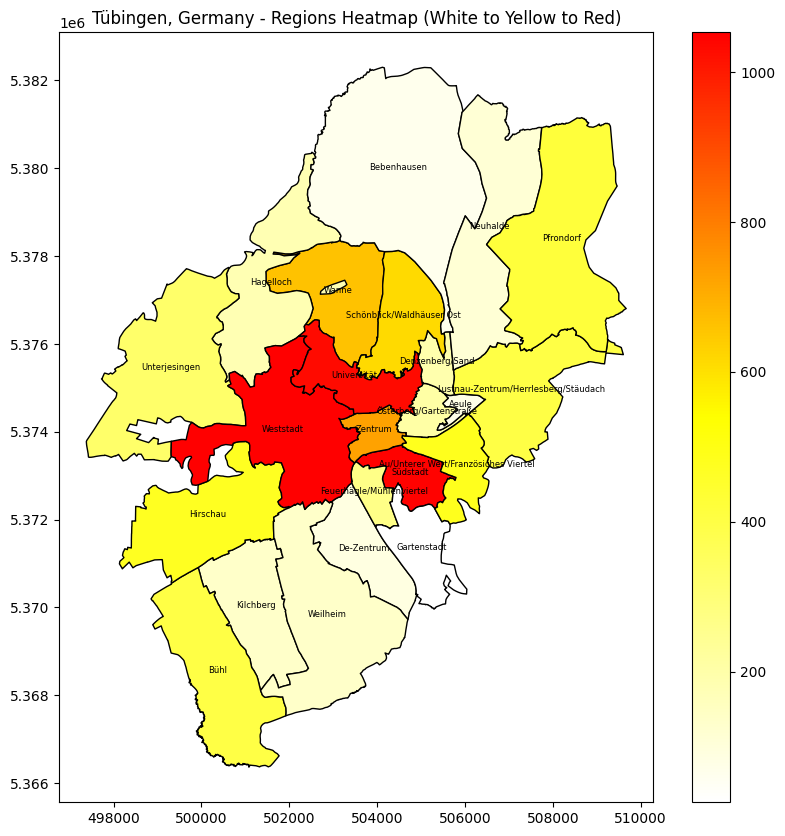

In [64]:
df_grouped = df_w_loc.groupby(["oadr_u2"]).size().reset_index(name='number_elements')
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = sorted_dict.keys()
tuebingen_gdf = tuebingen_gdf.join(df_grouped.set_index("oadr_u2"), on="region")
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="number_elements", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

# Show the plot
plt.show()



## ToDo Now

- [ ] Heatmap to usefull test statistics, like median or average rent
- [ ] maybe beautify heatmap aswell
- [ ] also maybe take ration into account, [Bevölkerung](https://www.tuebingen.de/Dateien/einwohner_stadtteile_Jahresvergleich.pdf) 

After that, one is going to ask - why is the mean renting price so much higher there, and then we look at the distribution of the prices in each region and find answers to that!
<br>
Maybe it is because of the way the flats are there(small flats only)

# Verlauf von den Mietpeisen in dne jeweiligen Regionen

### 1)
- wie viel Kaufeinträge haben wir pro stadtteil (links)
- wie viel Mieteinträge haben wir pro stadtteil (rechts)

### 2)
- Average Miete/Median Miete in den jeweiligen Stadtteilen
- Verlauf von Mietpreisen/Kauforeisen, Berechnung von slope (heatmap, je roter desto steiler slope), linear regression, etc.

### 3)
- ratio von Einträgen/Bewohner

### 4) 
- Generell welche Art von Wohnung ist wo, finde ich eine 4-Zimmer Wohnung in Lustnau? 
- wie viel Zimmer pro Stadtteil, wiviel Quadratmeter pro Stadtteil

## Make use of map, you know the situation, now make use and sense of it
- trends, surprises, explanations
- you finish abitur and wnat to look for a place to live with your 4 friends, where do you look?

-----------


## Kaufeinträge pro Stadtteil

In [65]:
# Kaufeinträge
df_w_loc.groupby(["oadr_u2", "nachfrageart"]).size().reset_index(name='count')

oadr_u2 nachfrageart  count
0                                  Aeule         kauf     26
1                                  Aeule        miete     50
2   Au/Unterer Wert/Französiches Viertel         kauf     90
3   Au/Unterer Wert/Französiches Viertel        miete    391
4                            Bebenhausen         kauf     19
5                            Bebenhausen        miete     44
6                                   Bühl         kauf    176
7                                   Bühl        miete    227
8                             De-Zentrum         kauf     20
9                             De-Zentrum        miete     70
10                       Denzenberg/Sand         kauf     45
11                       Denzenberg/Sand        miete    146
12              Feuerhägle/Mühlenviertel         kauf     55
13              Feuerhägle/Mühlenviertel        miete    214
14                           Gartenstadt         kauf      8
15                           Gartenstadt        miete     18
16                             Hagelloch         kauf     45
17                             Hagelloch        miete    137
18                              Hirschau         kauf    158
19                              Hirschau        miete    314
20                             Kilchberg         kauf     61
21                             Kilchberg        miete     77
22  Lustnau-Zentrum/Herrlesberg/Stäudach         kauf     62
23  Lustnau-Zentrum/Herrlesberg/Stäudach        miete    341
24                              Neuhalde         kauf     21
25                              Neuhalde        miete     90
26                             Pfrondorf         kauf    112
27                             Pfrondorf        miete    308
28             Schönblick/Waldhäuser Ost         kauf    139
29             Schönblick/Waldhäuser Ost        miete    475
30                              Südstadt         kauf    346
31                              Südstadt        miete    701
32                           Universität         kauf    186
33                           Universität        miete    844
34                         Unterjesingen         kauf    116
35                         Unterjesingen        miete    213
36                                 Wanne         kauf    208
37                                 Wanne        miete    453
38                              Weilheim         kauf     54
39                              Weilheim        miete     84
40                             Weststadt         kauf    319
41                             Weststadt        miete    734
42                               Zentrum         kauf    199
43                               Zentrum        miete    528
44                Österberg/Gartenstraße         kauf     47
45                Österberg/Gartenstraße        miete    160

In [66]:
df_kauf = df_w_loc[df_w_loc["nachfrageart"] == "kauf"].groupby(["oadr_u2"]).size().reset_index(name='count_kauf')
df_miete = df_w_loc[df_w_loc["nachfrageart"] == "miete"].groupby(["oadr_u2"]).size().reset_index(name='count_miete')

In [67]:
df_kauf

oadr_u2  count_kauf
0                                  Aeule          26
1   Au/Unterer Wert/Französiches Viertel          90
2                            Bebenhausen          19
3                                   Bühl         176
4                             De-Zentrum          20
5                        Denzenberg/Sand          45
6               Feuerhägle/Mühlenviertel          55
7                            Gartenstadt           8
8                              Hagelloch          45
9                               Hirschau         158
10                             Kilchberg          61
11  Lustnau-Zentrum/Herrlesberg/Stäudach          62
12                              Neuhalde          21
13                             Pfrondorf         112
14             Schönblick/Waldhäuser Ost         139
15                              Südstadt         346
16                           Universität         186
17                         Unterjesingen         116
18                                 Wanne         208
19                              Weilheim          54
20                             Weststadt         319
21                               Zentrum         199
22                Österberg/Gartenstraße          47

In [68]:
tuebingen_gdf = tuebingen_gdf.join(df_kauf.set_index("oadr_u2"), on="region")
tuebingen_gdf = tuebingen_gdf.join(df_miete.set_index("oadr_u2"), on="region")

In [69]:
# normalize
tuebingen_gdf["count_miete_normalized"] = tuebingen_gdf["count_miete"] / tuebingen_gdf["count_miete"].max()
tuebingen_gdf["count_kauf_normalized"] = tuebingen_gdf["count_kauf"] / tuebingen_gdf["count_miete"].max()


In [70]:
tuebingen_gdf

STT                                           geometry  \
0   017  POLYGON ((503797.299 5373237.931, 503796.260 5...   
1   141  POLYGON ((501347.373 5368108.085, 501347.345 5...   
2   031  POLYGON ((502556.148 5371633.120, 502555.725 5...   
3   151  POLYGON ((501081.664 5366361.284, 501081.604 5...   
4   015  POLYGON ((505153.410 5373868.879, 505153.094 5...   
5   022  POLYGON ((505736.190 5375415.014, 505736.419 5...   
6   013  POLYGON ((503751.717 5375735.066, 503751.565 5...   
7   032  POLYGON ((503629.452 5373238.842, 503629.655 5...   
8   026  POLYGON ((505417.314 5374039.556, 505415.652 5...   
9   014  POLYGON ((504850.099 5375727.705, 504849.562 5...   
10  181  MULTIPOLYGON (((501111.618 5375015.467, 501111...   
11  021  POLYGON ((505808.921 5375444.449, 505809.473 5...   
12  111  POLYGON ((505720.442 5376361.552, 505720.491 5...   
13  033  POLYGON ((503973.198 5371867.502, 503973.327 5...   
14  023  POLYGON ((505807.235 5375444.120, 505806.743 5...   
15  161  POLYGON ((500832.140 5373770.503, 500835.105 5...   
16  131  POLYGON ((502952.928 5367787.442, 502952.844 5...   
17  121  POLYGON ((509216.716 5375824.085, 509216.638 5...   
18  171  POLYGON ((500990.391 5374435.215, 500990.784 5...   
19  016  POLYGON ((506430.426 5373696.343, 506429.692 5...   
20  011  POLYGON ((504379.519 5374517.962, 504380.897 5...   
21  018  POLYGON ((503151.740 5374647.792, 503154.014 5...   
22  012  POLYGON ((504834.553 5375610.953, 504834.554 5...   

                                  region  number_elements  count_kauf  \
0                               Südstadt             1047         346   
1                              Kilchberg              138          61   
2                             De-Zentrum               90          20   
3                                   Bühl              403         176   
4                 Österberg/Gartenstraße              207          47   
5                        Denzenberg/Sand              191          45   
6                                  Wanne              661         208   
7               Feuerhägle/Mühlenviertel              269          55   
8                                  Aeule               76          26   
9              Schönblick/Waldhäuser Ost              614         139   
10                             Hagelloch              182          45   
11  Lustnau-Zentrum/Herrlesberg/Stäudach              403          62   
12                           Bebenhausen               63          19   
13                           Gartenstadt               26           8   
14                              Neuhalde              111          21   
15                              Hirschau              472         158   
16                              Weilheim              138          54   
17                             Pfrondorf              420         112   
18                         Unterjesingen              329         116   
19  Au/Unterer Wert/Französiches Viertel              481          90   
20                               Zentrum              727         199   
21                             Weststadt             1053         319   
22                           Universität             1030         186   

    count_miete  count_miete_normalized  count_kauf_normalized  
0           701                0.830569               0.409953  
1            77                0.091232               0.072275  
2            70                0.082938               0.023697  
3           227                0.268957               0.208531  
4           160                0.189573               0.055687  
5           146                0.172986               0.053318  
6           453                0.536730               0.246445  
7           214                0.253555               0.065166  
8            50                0.059242               0.030806  
9           475                0.562796               0.164692  
10          137                0.162322        

count_miete    844
dtype: int64


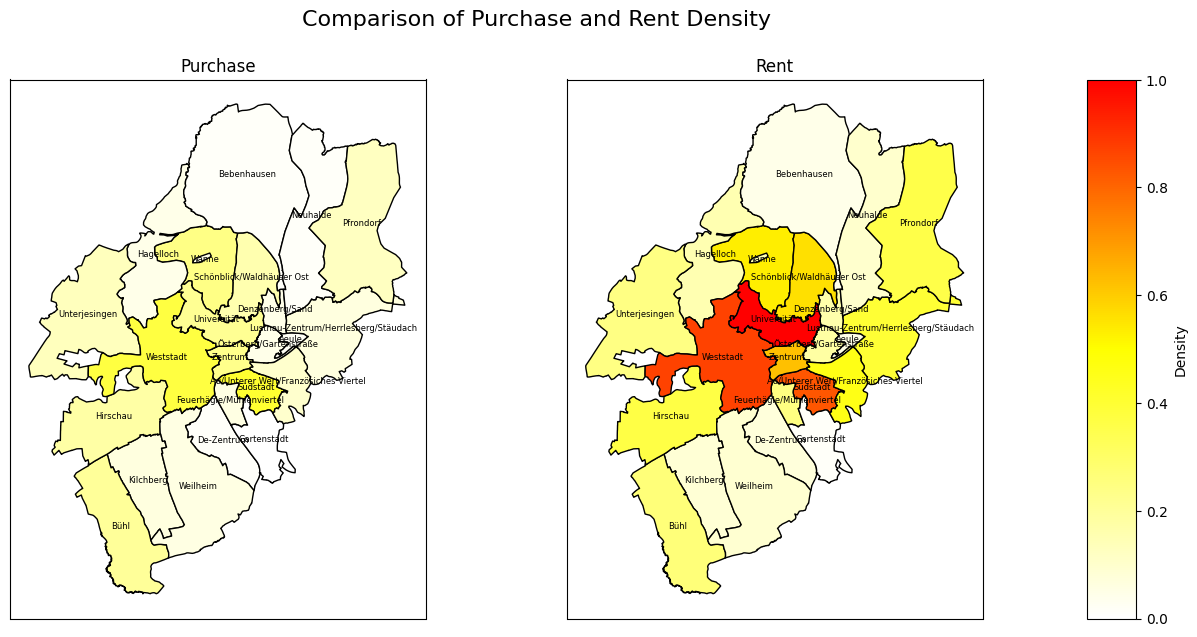

In [82]:
# https://stackoverflow.com/questions/44707213/generating-multiple-heatmaps-with-the-same-gradient

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

fig, axs = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [10, 10, 1]})

# Plot the GeoDataFrame with heatmaps based on density values using the custom colormap
vmax = tuebingen_gdf[["count_miete"]].max()
vmin = tuebingen_gdf[["count_kauf"]].min()
print(vmax)
for ax, density_column, title in zip(axs[:-1], ["count_kauf", "count_miete"], ["Purchase", "Rent"]):
    tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column=density_column, legend=False, vmin=vmin, vmax=vmax) # vmin und vmax machen magic, check nach ob stimmt
    ax.set_title(title)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])

# Add labels and legend
cax = axs[-1]
sm = plt.cm.ScalarMappable(cmap=cmap_white_yellow_red)
sm.set_array([])  # You need to set an array even if empty
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Density')

for ax, density_column in zip(axs[:-1], ["count_kauf", "count_miete"]):
    for idx, row in tuebingen_gdf.iterrows():
        ax.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Set overall title
fig.suptitle('Comparison of Purchase and Rent Density', fontsize=16)

# Adjust layout to prevent clipping of titles


# Show th



# Show the plot
plt.show()



--------------

# Bearbeitete Plots

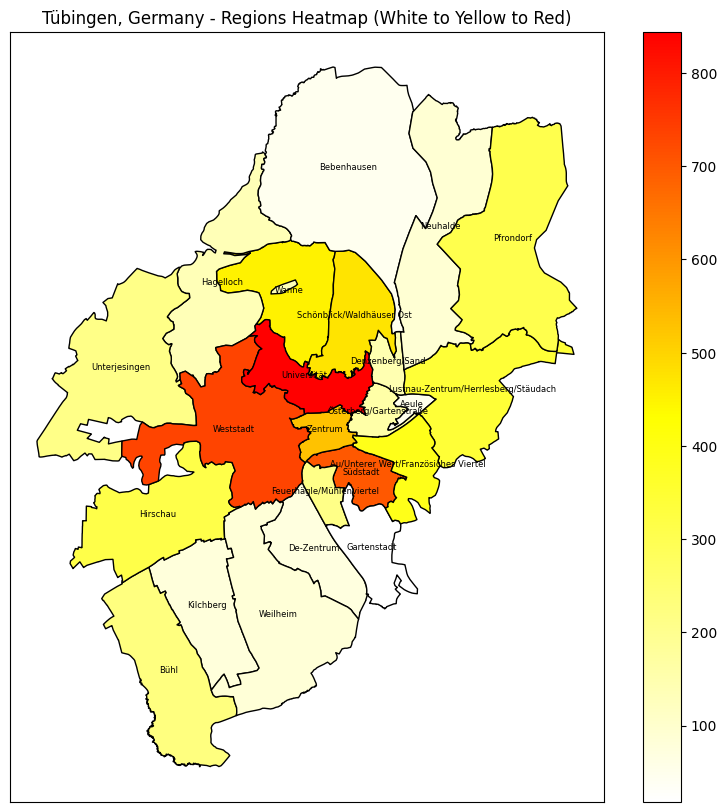

In [117]:
# rent
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="count_miete", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
# Show the plot
plt.show()



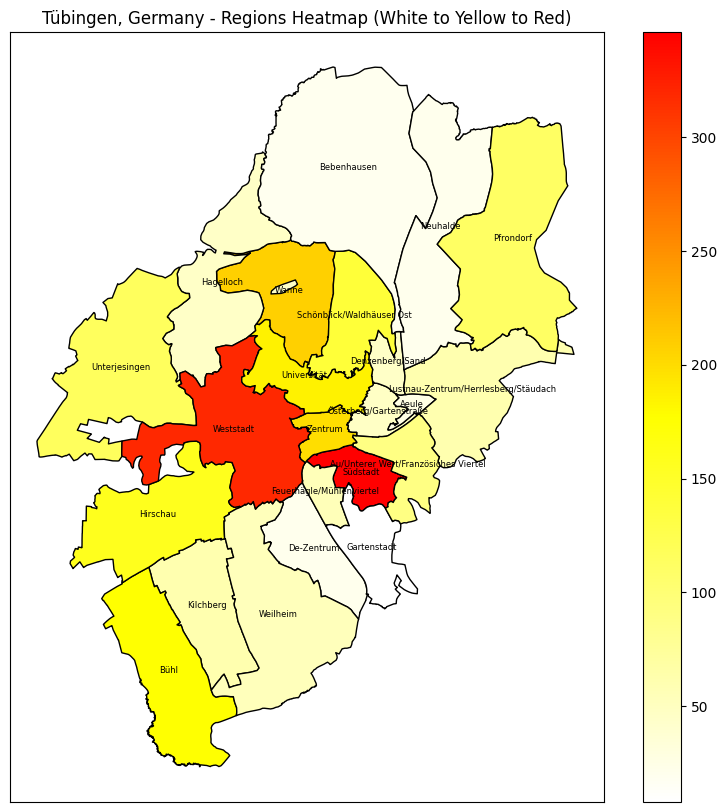

In [86]:

cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="count_kauf", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
# Show the plot
plt.show()



In [87]:
short_labels = {
    'Südstadt': 'Sdst',
    'Kilchberg': 'Klb',
    'De-Zentrum': 'DZtrm',
    'Bühl': 'Bhl',
    'Österberg/Gartenstraße': 'Ost/Gstr',
    'Denzenberg/Sand': 'Dzb/Snd',
    'Wanne': 'Wn',
    'Feuerhägle/Mühlenviertel': 'Fhgl/Mvrtl',
    'Aeule': 'Ae',
    'Schönblick/Waldhäuser Ost': 'Sbl/Wo',
    'Hagelloch': 'Hgl',
    'Lustnau-Zentrum/Herrlesberg/Stäudach': 'Lnz/Hst',
    'Bebenhausen': 'Bbh',
    'Gartenstadt': 'Gstdt',
    'Neuhalde': 'Nhd',
    'Hirschau': 'Hrsch',
    'Weilheim': 'Wlm',
    'Pfrondorf': 'Pfrd',
    'Unterjesingen': 'Ujsg',
    'Au/Unterer Wert/Französiches Viertel': 'Au/Uw/Fv',
    'Zentrum': 'Ztrm',
    'Weststadt': 'Wstd',
    'Universität': 'Univ'
}


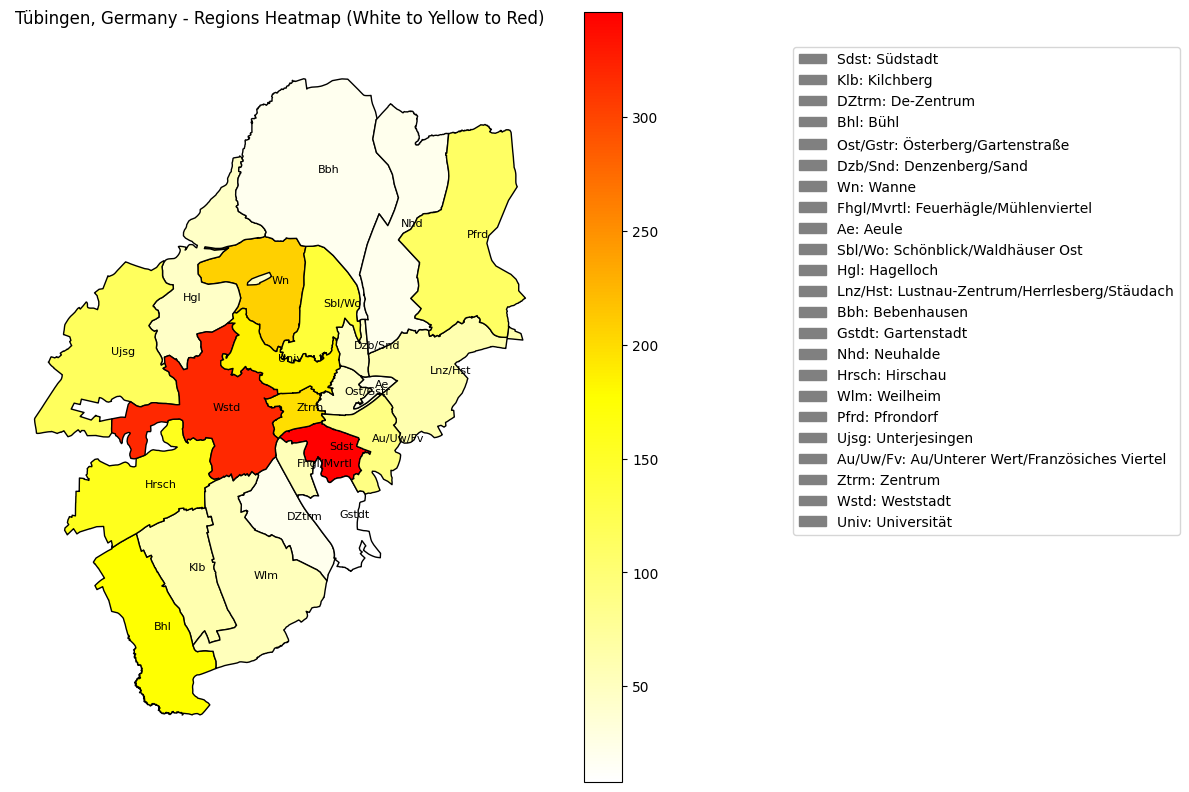

In [144]:

# purchase
from matplotlib.patches import Polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="count_kauf", legend=True)

# Add shortened labels for each region
for idx, row in tuebingen_gdf.iterrows():
    short_label = short_labels.get(row["region"], row["region"])  # Use the short label if available
    x,y = row["geometry"].centroid.coords[0]
    if row["region"] == "Wanne":
        x,y= x+200.0105, y-0.0005
    if row["region"] == "Hagelloch":
        x,y= x-500.0105, y-600.0005
    plt.annotate(short_label, xy=(x,y), fontsize=8, color='black')
    

    

plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

ax.set_axis_off()
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


ax.set_axis_off()

# Now we will create the legend for the short labels manually.
# We create a list of patches for the legend
legend_patches = [mpatches.Patch(color='grey', label=f'{short}: {region}') for region, short in short_labels.items()]


# Add the building marker to your list of legend patches

plt.legend(handles=legend_patches,bbox_to_anchor=(1.45, 1), loc=2, borderaxespad=0.)


plt.subplots_adjust(right=0.8)  # Adjust this as needed

# Show the plot
plt.show()



plt.show()


### Noch zu tuen
- Die Legende vielleicht farblich wie das polygon ?
- Oder zumindest aufsteigend bzw absteigend sortieren, man schaut intuitiv immer bei roten eher oben in der Liste
- hätte effekt das wir direkt noch sehen was oben und unten ist

### Getan
- purchase und miete mal getrennt in seperate plots
- die müssen wir nur noch jetzt in eine figure
- hab kürzel hinzugefügt
- kann jetzt die labels in den polygon plot direkt adressieren, zumindest die position 


# Take population into account

## Nutze den Link von oben für Bevölkerung

In [72]:
data = {
    "region": [
        "Zentrum", "Universität", "Wanne", "Schönblick/Waldhäuser Ost",
        "Österberg/Gartenstraße", "Au/Unterer Wert/Französiches Viertel",
        "Südstadt", "Weststadt", "Lustnau-Zentrum/Herrlesberg/Stäudach",
        "Denzenberg/Sand", "Neuhalde", "Aeule", "De-Zentrum",
        "Feuerhägle/Mühlenviertel", "Gartenstadt", "Bebenhausen",
        "Pfrondorf", "Weilheim", "Kilchberg", "Bühl", "Hirschau",
        "Unterjesingen", "Hagelloch", "Gesamt"
    ],
    "2016": [
        6430, 8242, 5384, 9779, 2509, 3656, 10459, 8519, 5908,
        2421, 1261, 985, 1863, 4484, 494, 343, 3343, 1498, 1252,
        2114, 3289, 2580, 1713, 88526
    ],
    "2017": [
        6503, 8299, 5370, 9878, 2580, 3832, 10484, 8622, 5950,
        2438, 1287, 988, 1860, 4857, 496, 328, 3360, 1468, 1271,
        2125, 3288, 2624, 1702, 89610
    ],
    "2018": [
        6479, 8524, 5359, 9838, 2580, 4248, 10518, 8687, 5957,
        2479, 1318, 995, 1888, 5191, 473, 338, 3363, 1445, 1299,
        2145, 3304, 2627, 1709, 90764
    ],
    "2019": [
        6516, 8618, 5528, 9968, 2632, 4678, 10618, 8778, 6037,
        2499, 1315, 984, 1846, 5110, 473, 326, 3348, 1467, 1295,
        2172, 3276, 2640, 1715, 91839
    ],
    "2020": [
        6371, 8445, 5469, 9772, 2685, 4997, 10519, 8607, 5910,
        2550, 1320, 977, 1810, 4806, 463, 333, 3319, 1446, 1287,
        2154, 3297, 2627, 1713, 90877
    ],
    "2021": [
        6501, 8593, 5541, 9959, 2708, 5291, 10578, 8708, 5930,
        2605, 1300, 958, 1789, 5061, 457, 336, 3315, 1443, 1274,
        2171, 3359, 2566, 1727, 92170
    ],
    "2022": [
        6540, 8568, 5665, 10004, 2707, 5272, 10616, 8828, 5952,
        2586, 1287, 1033, 1780, 5206, 459, 322, 3348, 1475, 1266,
        2182, 3384, 2567, 1753, 92800
    ]
}

# Erstellen des DataFrames
df_people = pd.DataFrame(data)
df_people = df_people.set_index("region")

print(df)


       angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
0      3594713336         NaN         2.0                       0   
1      3594016393         NaN         2.0                       0   
2      3593975043         NaN         1.0                       0   
3      3594255459         1.0         3.0                       0   
4      3594061704         1.0         3.0                       0   
...           ...         ...         ...                     ...   
16003  3041045247         NaN         2.5                       0   
16004  3040210896         NaN         4.0                       0   
16005  3058502400         NaN         7.0                       0   
16006  3032926122         NaN         4.0                       0   
16007  3043830326         NaN         7.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
0                          1                        0   
1                          1                        0   


### Calculate average per population per region, aint no much difference between the years, I guess its legit to do that

In [73]:
# calculate mean from 2016 to 2022
mean_pop = df_people.mean(axis=1).round(0).astype(int)
mean_pop

region
Zentrum                                  6477
Universität                              8470
Wanne                                    5474
Schönblick/Waldhäuser Ost                9885
Österberg/Gartenstraße                   2629
Au/Unterer Wert/Französiches Viertel     4568
Südstadt                                10542
Weststadt                                8678
Lustnau-Zentrum/Herrlesberg/Stäudach     5949
Denzenberg/Sand                          2511
Neuhalde                                 1298
Aeule                                     989
De-Zentrum                               1834
Feuerhägle/Mühlenviertel                 4959
Gartenstadt                               474
Bebenhausen                               332
Pfrondorf                                3342
Weilheim                                 1463
Kilchberg                                1278
Bühl                                     2152
Hirschau                                 3314
Unterjesingen              

### merge them

In [74]:
tuebingen_gdf = tuebingen_gdf.join(mean_pop.rename("population"), on="region")

tuebingen_gdf

STT                                           geometry  \
0   017  POLYGON ((503797.299 5373237.931, 503796.260 5...   
1   141  POLYGON ((501347.373 5368108.085, 501347.345 5...   
2   031  POLYGON ((502556.148 5371633.120, 502555.725 5...   
3   151  POLYGON ((501081.664 5366361.284, 501081.604 5...   
4   015  POLYGON ((505153.410 5373868.879, 505153.094 5...   
5   022  POLYGON ((505736.190 5375415.014, 505736.419 5...   
6   013  POLYGON ((503751.717 5375735.066, 503751.565 5...   
7   032  POLYGON ((503629.452 5373238.842, 503629.655 5...   
8   026  POLYGON ((505417.314 5374039.556, 505415.652 5...   
9   014  POLYGON ((504850.099 5375727.705, 504849.562 5...   
10  181  MULTIPOLYGON (((501111.618 5375015.467, 501111...   
11  021  POLYGON ((505808.921 5375444.449, 505809.473 5...   
12  111  POLYGON ((505720.442 5376361.552, 505720.491 5...   
13  033  POLYGON ((503973.198 5371867.502, 503973.327 5...   
14  023  POLYGON ((505807.235 5375444.120, 505806.743 5...   
15  161  POLYGON ((500832.140 5373770.503, 500835.105 5...   
16  131  POLYGON ((502952.928 5367787.442, 502952.844 5...   
17  121  POLYGON ((509216.716 5375824.085, 509216.638 5...   
18  171  POLYGON ((500990.391 5374435.215, 500990.784 5...   
19  016  POLYGON ((506430.426 5373696.343, 506429.692 5...   
20  011  POLYGON ((504379.519 5374517.962, 504380.897 5...   
21  018  POLYGON ((503151.740 5374647.792, 503154.014 5...   
22  012  POLYGON ((504834.553 5375610.953, 504834.554 5...   

                                  region  number_elements  count_kauf  \
0                               Südstadt             1047         346   
1                              Kilchberg              138          61   
2                             De-Zentrum               90          20   
3                                   Bühl              403         176   
4                 Österberg/Gartenstraße              207          47   
5                        Denzenberg/Sand              191          45   
6                                  Wanne              661         208   
7               Feuerhägle/Mühlenviertel              269          55   
8                                  Aeule               76          26   
9              Schönblick/Waldhäuser Ost              614         139   
10                             Hagelloch              182          45   
11  Lustnau-Zentrum/Herrlesberg/Stäudach              403          62   
12                           Bebenhausen               63          19   
13                           Gartenstadt               26           8   
14                              Neuhalde              111          21   
15                              Hirschau              472         158   
16                              Weilheim              138          54   
17                             Pfrondorf              420         112   
18                         Unterjesingen              329         116   
19  Au/Unterer Wert/Französiches Viertel              481          90   
20                               Zentrum              727         199   
21                             Weststadt             1053         319   
22                           Universität             1030         186   

    count_miete  count_miete_normalized  count_kauf_normalized  population  
0           701                0.830569               0.409953       10542  
1            77                0.091232               0.072275        1278  
2            70                0.082938               0.023697        1834  
3           227                0.268957               0.208531        2152  
4           160                0.189573               0.055687        2629  
5           146                0.172986               0.053318        2511  
6           453                0.536730               0.246445        5474  
7           214                0.253555               0.065166        4959  
8            50                0.059242               0.030806       

In [75]:
tuebingen_gdf["ratio"] = tuebingen_gdf["number_elements"] / tuebingen_gdf["population"]

## Plot the ratio, number of flats divided by population

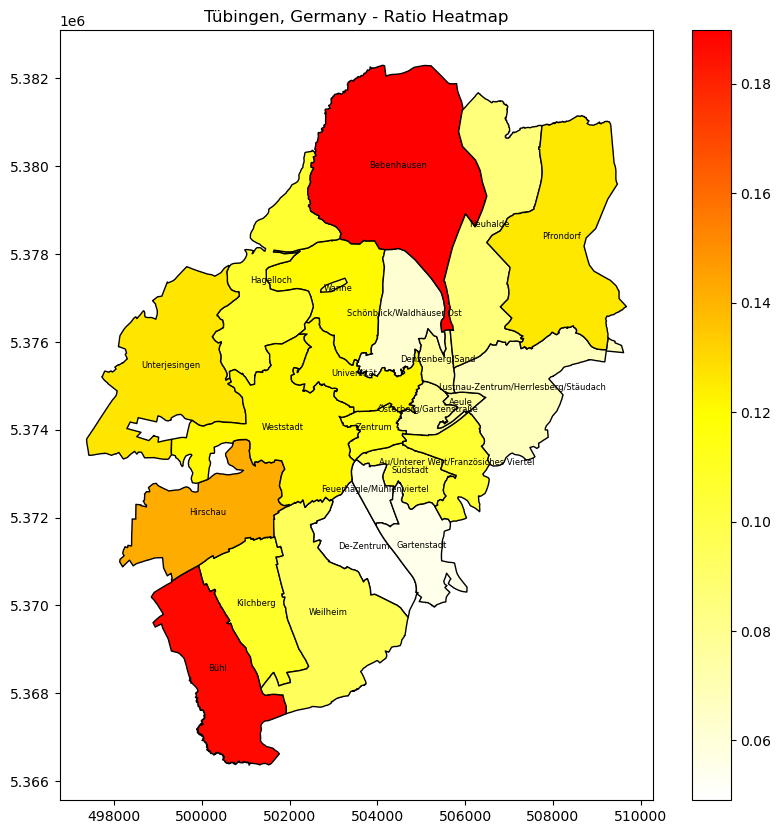

In [55]:
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="ratio", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Ratio Heatmap')

# Show the plot
plt.show()



## Bringt uns das was ?

## Ausserdem
Wie alt sind die Regionen, im Sinne von Wohnungen und Häuser

## Potenzielle Erklärungsversuche, Spekulation ?

# Scatter plot und lineare Regression

Falls der approach nicht gut aussieht, müssen wir vielleicht auf polynomial regression umsteigen

In [56]:
interesting_regions = ["Zentrum", "Universität", "Wanne", "Schönblick/Waldhäuser Ost",]
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15991    58854993         1.0         3.0                       0   
15992    53677475         1.0         3.0                       0   
15993    44458486         2.0         5.5                       0   
15995    43152961         2.0         4.0                       0   
...           ...         ...         ...                     ...   
34     3592611553         1.0         4.0                       0   
33     3592611568         1.0         3.0                       0   
32     3592611656         1.0         3.0                       0   
45     3592318756         1.0         1.0                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15991                      1                        0   
15992                      0                        0   
15993                      0                        1   
15995                      0                        0   
...                      ...                      ...   
34                         0                        0   
33                         0                        0   
32                         0                        0   
45                         0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15991                           1                     1   
15992                           1                     1   
15993                           0                     1   
15995                           0                     1   
...                           ...                   ...   
34                              0                     0   
33                              0                     0   
32                              0                     0   
45                              0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15991                         0                          0   
15992                         0                          0   
15993                         0                          0   
15995                         0                          0   
...                         ...                        ...   
34                            0                          0   
33                            0                          0   
32                            0                          0   
45                            0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15991                           0                          0   
15992                           0                          0   
15993                           0                          0   
15995                           0                          0   
...                           ...                        ...   
34                              0                          0   
33                              0                          0   
32                              0                          0   
45                              0                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15991                        0                 Gas   
15992                        0                 NaN   
15993                        0                  Öl   


In [57]:
df_w_loc['year_month'] = df_w_loc['year'].astype(str) + '-' + df_w_loc['month'].astype(str).str.zfill(2)
df_w_loc = df_w_loc.sort_values(by=['year_month'])
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15996    40706032         2.0         3.0                       0   
16001    27375419         1.0         6.0                       0   
15998    27439257         1.0         5.0                       0   
15997    40569012         NaN         5.0                       0   
...           ...         ...         ...                     ...   
3      3594255459         1.0         3.0                       0   
2      3593975043         NaN         1.0                       0   
26     3592807854         1.0         NaN                       0   
8      3593834802         8.0        18.5                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15996                      1                        0   
16001                      1                        1   
15998                      1                        1   
15997                      0                        1   
...                      ...                      ...   
3                          1                        1   
2                          0                        0   
26                         0                        1   
8                          0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15996                           1                     1   
16001                           0                     0   
15998                           0                     1   
15997                           1                     0   
...                           ...                   ...   
3                               0                     1   
2                               0                     0   
26                              0                     0   
8                               0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15996                         0                          0   
16001                         0                          0   
15998                         0                          0   
15997                         0                          0   
...                         ...                        ...   
3                             0                          0   
2                             0                          0   
26                            0                          0   
8                             0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15996                           0                          0   
16001                           0                          1   
15998                           0                          0   
15997                           0                          0   
...                           ...                        ...   
3                               0                          0   
2                               0                          0   
26                              0                          0   
8                               1                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15996                        0                 Gas   
16001                        0          Alternativ   
15998                        0                 Gas   


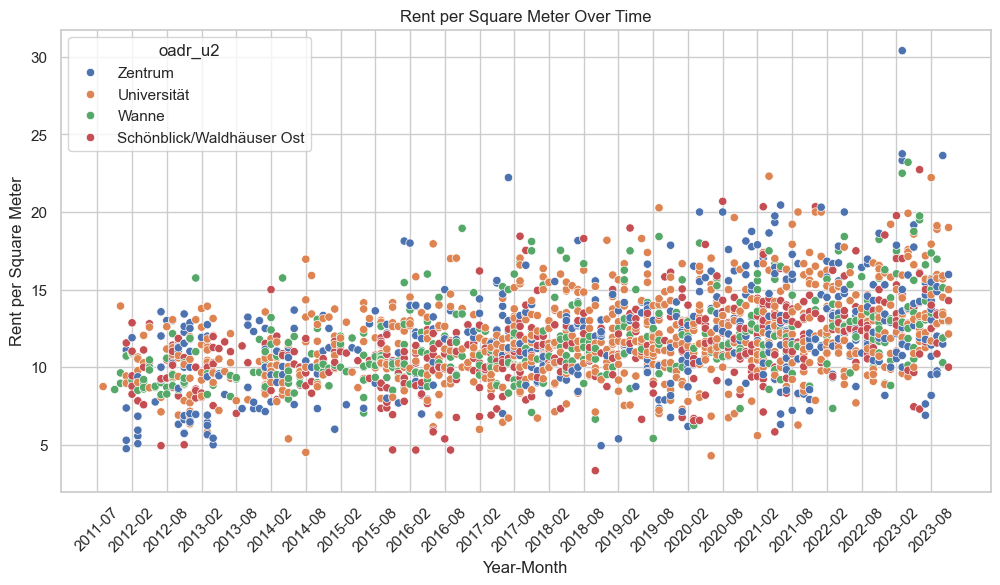

In [58]:
df_w_loc_interesting = df_w_loc[df_w_loc["oadr_u2"].isin(interesting_regions)]
# scatter plot with seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=df_w_loc_interesting, x="year_month", y="kstn_miete_kalt_pqm", hue="oadr_u2")
plt.title('Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.xticks(df_w_loc_interesting['year_month'].unique()[::6], rotation=45)
plt.ylabel('Rent per Square Meter')
plt.show()

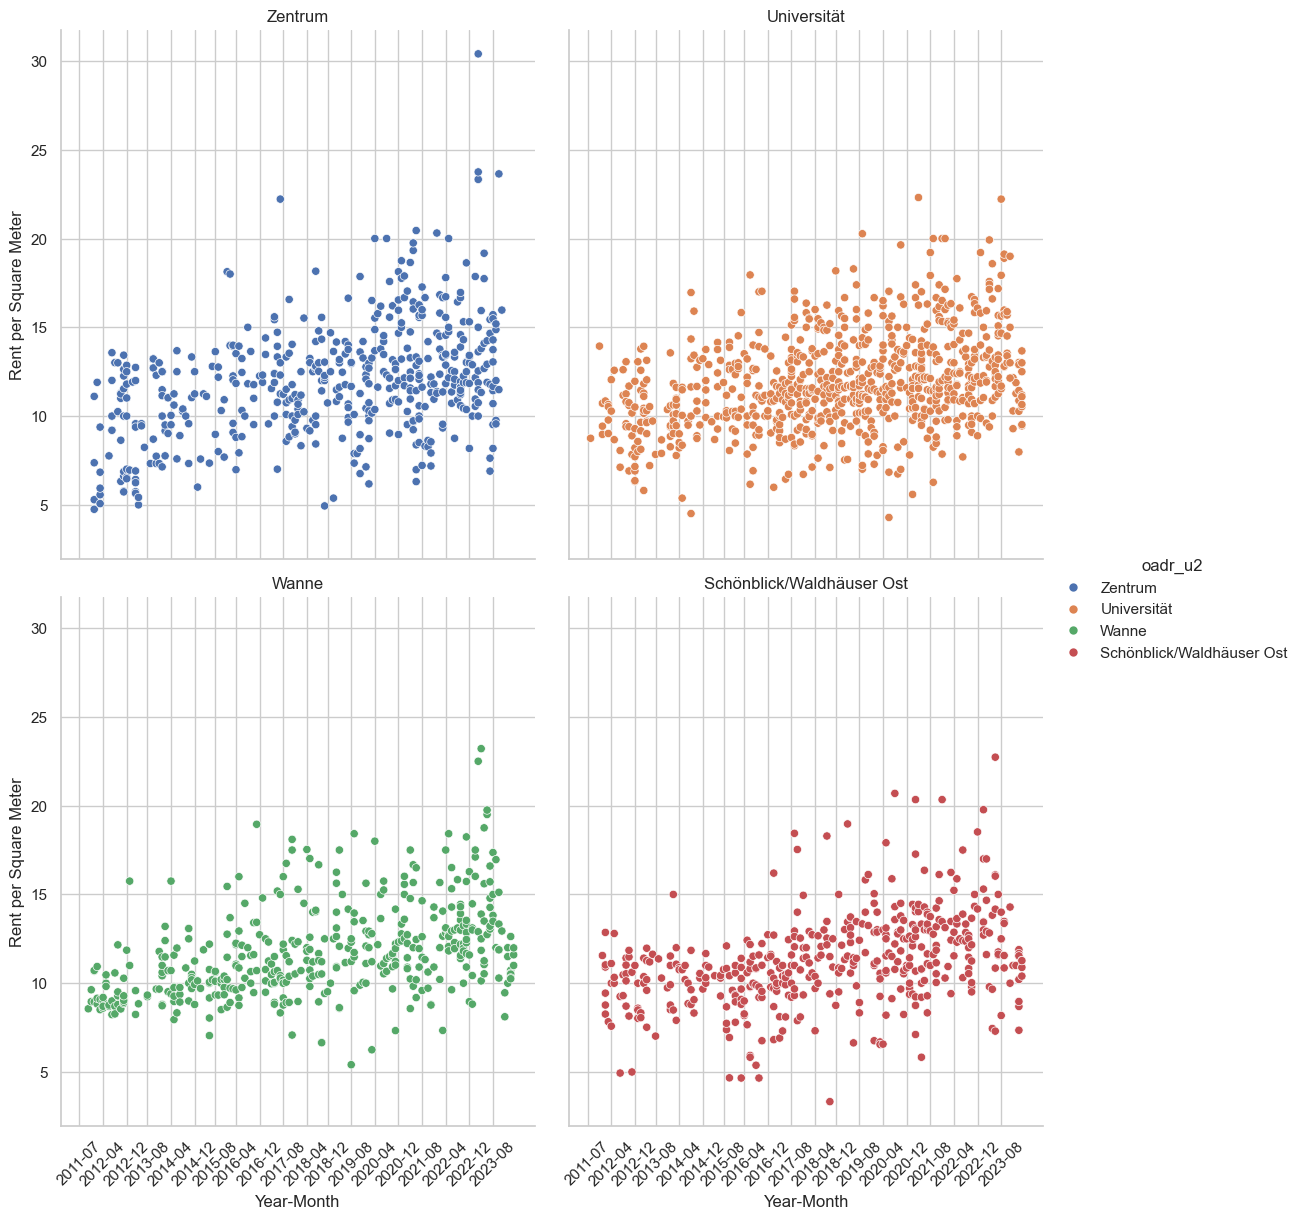

In [61]:
g = sns.relplot(
    data=df_w_loc_interesting,
    x="year_month", y="kstn_miete_kalt_pqm", col="oadr_u2",
    hue="oadr_u2",
    kind="scatter",
    height=6, aspect=0.9,  # Adjust height and aspect ratio to control the size,
    col_wrap=2
)

# Adjust the x-ticks rotation and interval
for ax in g.axes.flat:
    ax.set_xticks(df_w_loc_interesting['year_month'].unique()[::8])
    ax.set_xticklabels(df_w_loc_interesting['year_month'].unique()[::8], rotation=45)

# Adjust the title and labels
g.set_titles("{col_name}")
g.set_axis_labels("Year-Month", "Rent per Square Meter")

# Show the plot
plt.show()

## Linear regression
Weil wir als X-Werte das Datum haben, können wir nicht einfach linear regression anwenden. Wir gehen wie folgt vor:
1) Wir ändern unsere Werte zu ordinalen Werten
2) Splitten x und y
3) Fitten die Kurve
4) Ploten die Kurve in die scatter plots rein

### 1) Ordinal values

In [100]:
df_w_loc_interesting_copy = df_w_loc_interesting.copy()
df_w_loc_interesting_copy["startdate"]

15998    2011-07-23
15989    2011-08-02
15979    2011-08-09
15978    2011-08-09
15957    2011-09-09
            ...    
28       2023-11-07
3        2023-11-14
2        2023-11-15
26       2023-11-08
1        2023-11-15
Name: startdate, Length: 3032, dtype: object

In [101]:
import datetime as dt
df_w_loc_interesting_copy['startdate'] = pd.to_datetime(df_w_loc_interesting_copy['startdate'])
df_w_loc_interesting_copy['startdate_ordinal']=df_w_loc_interesting_copy['startdate'].map(dt.datetime.toordinal)
df_w_loc_interesting_copy['startdate_ordinal']

15998    734341
15989    734351
15979    734358
15978    734358
15957    734389
          ...  
28       738831
3        738838
2        738839
26       738832
1        738839
Name: startdate_ordinal, Length: 3032, dtype: int64

### 2) Split x and y

In [102]:
from sklearn.linear_model import LinearRegression

In [103]:
df_w_loc_interesting_copy["kstn_miete_kalt_pqm"].isna().sum()

803

In [104]:
df_w_loc_interesting_copy = df_w_loc_interesting_copy[df_w_loc_interesting_copy["kstn_miete_kalt_pqm"].notna()]

In [112]:
df_w_loc_interesting_copy

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
15858  1754171214         1.0         2.0                       0   
15726  1971310643         NaN         1.0                       0   
15728  1970802426         1.0         2.0                       0   
15709  1982955032         1.0         1.0                       0   
15706  1982967266         NaN         2.0                       0   
...           ...         ...         ...                     ...   
244    3584614029         2.0         5.5                       0   
203    3586340660         NaN         2.0                       0   
197    3586491042         NaN         4.0                       0   
112    3589717385         NaN         1.0                       0   
3      3594255459         1.0         3.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
15858                      0                        0   
15726                      0                        0   
15728                      0                        0   
15709                      0                        0   
15706                      0                        0   
...                      ...                      ...   
244                        1                        1   
203                        0                        0   
197                        0                        1   
112                        0                        0   
3                          1                        1   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
15858                           0                     0   
15726                           0                     1   
15728                           0                     1   
15709                           0                     0   
15706                           0                     0   
...                           ...                   ...   
244                             1                     0   
203                             0                     0   
197                             0                     0   
112                             0                     0   
3                               0                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
15858                         0                          0   
15726                         0                          0   
15728                         0                          0   
15709                         0                          0   
15706                         0                          0   
...                         ...                        ...   
244                           0                          0   
203                           0                          0   
197                           0                          0   
112                           0                          0   
3                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
15858                           0                          0   
15726                           0                          0   
15728                           0                          0   
15709                           0                          0   
15706                           0                          0   
...                           ...                        ...   
244                             0                          0   
203                             0                          0   
197                             0                          0   
112                             0                          0   
3                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
15858                        0                 NaN   
15726                        0                 Gas   
15728                        0                 NaN   
15709                        0                 NaN   


In [105]:
df_w_loc_interesting_copy_uni=df_w_loc_interesting_copy[df_w_loc_interesting_copy["oadr_u2"] == "Universität"]
df_w_loc_interesting_copy["startdate_ordinal_better_scale"] = df_w_loc_interesting_copy["startdate_ordinal"] - df_w_loc_interesting_copy["startdate_ordinal"].min()

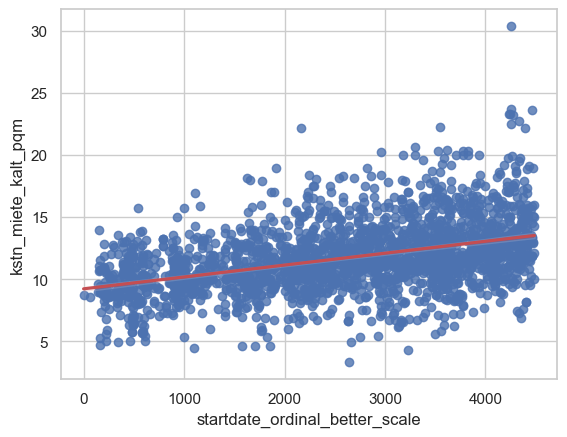

In [106]:
ax = sns.regplot(
    data=df_w_loc_interesting_copy,
    x='startdate_ordinal_better_scale',
    y='kstn_miete_kalt_pqm',
    line_kws=dict(color="r")
    
)

In [107]:
lg_df = pd.DataFrame(columns=["oadr_u2", "r_sq", "intercept", "slope"])
df_w_loc_interesting_copy=df_w_loc_interesting_copy.sort_values(by=["oadr_u2", 'startdate_ordinal'])
df_w_loc_interesting_copy["startdate_ordinal_better_scale"] = df_w_loc_interesting_copy["startdate_ordinal"] - df_w_loc_interesting_copy["startdate_ordinal"].min()
for i in interesting_regions:
    x = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "startdate_ordinal"]
    
    y = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "kstn_miete_kalt_pqm"]
    x = x.values.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    intercept = model.intercept_
    slope=model.coef_[0]
    lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope}, ignore_index=True)
lg_df

/var/folders/hy/0tzp89gx4dg8lszwqth6dv6r0000gn/T/ipykernel_2516/4080631259.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope}, ignore_index=True)


oadr_u2      r_sq   intercept     slope
0                    Zentrum  0.171994 -770.666111  0.001062
1                Universität  0.136493 -614.075777  0.000849
2                      Wanne  0.237278 -722.686757  0.000997
3  Schönblick/Waldhäuser Ost  0.183645 -672.131696  0.000927

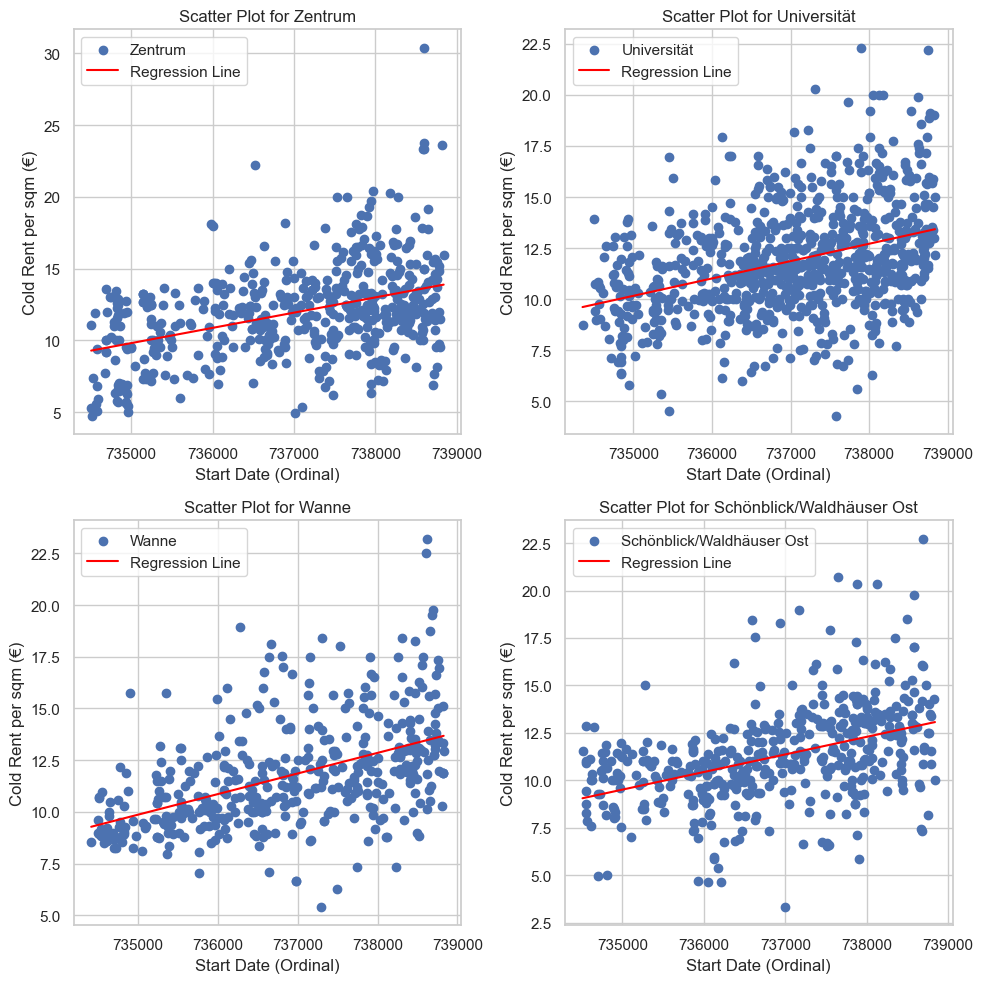

In [140]:


import matplotlib.dates as mdates
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(interesting_regions):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y, color='red', label='Regression Line')
    
    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

/var/folders/hy/0tzp89gx4dg8lszwqth6dv6r0000gn/T/ipykernel_2516/1997906188.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
/var/folders/hy/0tzp89gx4dg8lszwqth6dv6r0000gn/T/ipykernel_2516/1997906188.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
/var/folders/hy/0tzp89gx4dg8lszwqth6dv6r0000gn/T/ipykernel_2516/1997906188.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
/var/folders/hy/0tzp89gx4dg8lszwqth6dv6r0000gn/T/ipykernel_2516/1997906188.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_tick

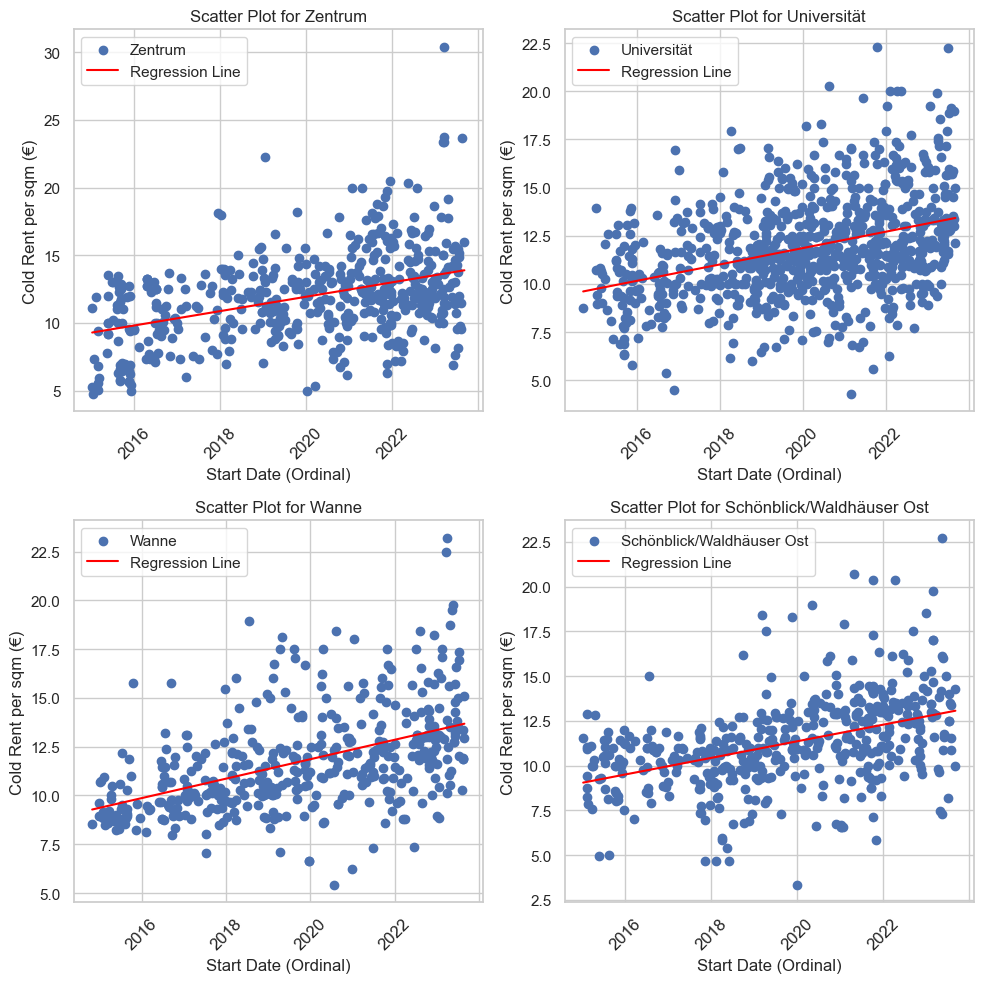

In [119]:


import matplotlib.dates as mdates
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(interesting_regions):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y, color='red', label='Regression Line')
    
    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    x_ticks_labels = ['2012','2016','2018','2020','2022']
    ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

## rf

In [149]:
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15996    40706032         2.0         3.0                       0   
16001    27375419         1.0         6.0                       0   
15998    27439257         1.0         5.0                       0   
15997    40569012         NaN         5.0                       0   
...           ...         ...         ...                     ...   
3      3594255459         1.0         3.0                       0   
2      3593975043         NaN         1.0                       0   
26     3592807854         1.0         NaN                       0   
8      3593834802         8.0        18.5                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15996                      1                        0   
16001                      1                        1   
15998                      1                        1   
15997                      0                        1   
...                      ...                      ...   
3                          1                        1   
2                          0                        0   
26                         0                        1   
8                          0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15996                           1                     1   
16001                           0                     0   
15998                           0                     1   
15997                           1                     0   
...                           ...                   ...   
3                               0                     1   
2                               0                     0   
26                              0                     0   
8                               0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15996                         0                          0   
16001                         0                          0   
15998                         0                          0   
15997                         0                          0   
...                         ...                        ...   
3                             0                          0   
2                             0                          0   
26                            0                          0   
8                             0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15996                           0                          0   
16001                           0                          1   
15998                           0                          0   
15997                           0                          0   
...                           ...                        ...   
3                               0                          0   
2                               0                          0   
26                              0                          0   
8                               1                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15996                        0                 Gas   
16001                        0          Alternativ   
15998                        0                 Gas   


In [161]:
# drop all nan values
interesting_cols = ["anz_zimmer", "aus_heiz_system", "aus_kueche_einbau_janein", "aus_pool_janein", "baujahr", "flaeche", "kstn_miete_kalt_pqm"]
# filter based on interesting_cols
df_w_loc_interesting_rf = df_w_loc[interesting_cols]
# replace every nan with 0
df_w_loc_interesting_rf = df_w_loc_interesting_rf.fillna(0)


non_numeric_columns = df_w_loc_interesting_rf.select_dtypes(exclude=[np.number]).columns



# Apply one-hot encoding
df_encoded = pd.get_dummies(df_w_loc_interesting_rf, columns=non_numeric_columns)


In [162]:
df_w_loc_interesting_rf

anz_zimmer aus_heiz_system  aus_kueche_einbau_janein  aus_pool_janein  \
16004         4.0         Zentral                         1                0   
15996         3.0         Zentral                         1                0   
16001         6.0         Zentral                         0                0   
15998         5.0               0                         0                0   
15997         5.0           Etage                         1                0   
...           ...             ...                       ...              ...   
3             3.0         Zentral                         0                0   
2             1.0               0                         1                0   
26            0.0               0                         0                0   
8            18.5         Zentral                         0                0   
1             2.0               0                         1                0   

       baujahr  flaeche  kstn_miete_kalt_pqm  
16004      0.0    87.00                 7.24  
15996   2001.0    72.65                 0.00  
16001      0.0   147.00                 0.00  
15998   2011.0   168.70                 0.00  
15997   1515.0   147.00                 9.69  
...        ...      ...                  ...  
3       2011.0   109.58                15.97  
2       1984.0    40.00                10.00  
26         0.0   219.87                 0.00  
8       1876.0   576.50                 0.00  
1       1980.0    50.00                15.00  

[11927 rows x 7 columns]

In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
df = df_encoded
# Assuming df is your DataFrame and 'kstn_miete_kalt_pqm' is the target variable (price)
X = df.drop('kstn_miete_kalt_pqm', axis=1)  # Features
y = df['kstn_miete_kalt_pqm']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature flaeche (0.41336331232491585)
2. feature baujahr (0.2991940240629079)
3. feature anz_zimmer (0.13657552680227042)
4. feature aus_kueche_einbau_janein (0.09187386359728096)
5. feature aus_heiz_system_0 (0.022350888575332087)
6. feature aus_heiz_system_Zentral (0.02187708972545537)
7. feature aus_heiz_system_Etage (0.009050040322252767)
8. feature aus_heiz_system_Zimmer (0.005346120043272108)
9. feature aus_pool_janein (0.00036913454631252627)


In [165]:
import shap

# Initialize the SHAP values calculator
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


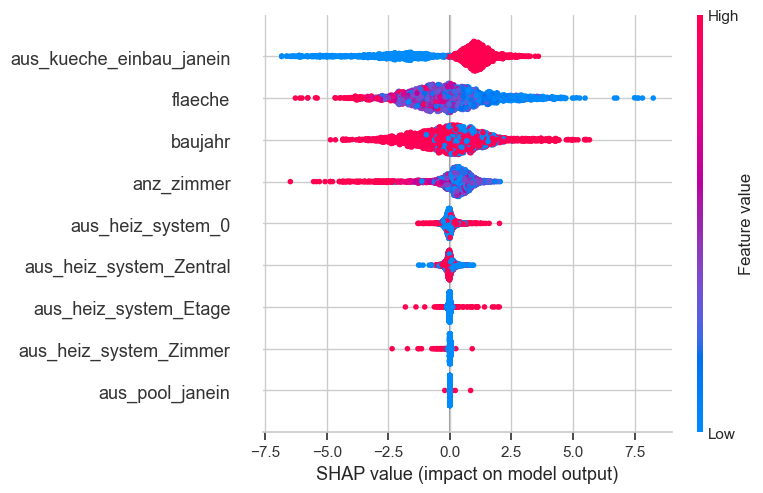

In [166]:
# Create a summary plot for all the test set predictions
shap.summary_plot(shap_values, X_test)


In [176]:
df_w_loc[df_w_loc["oadr_u2"].notna()]["baujahr"].isna().sum()

2106

In [177]:
df_w_loc["oadr_u2"].isna().sum()

2796

In [167]:
df_w_loc["baujahr"].isna().sum()

2872

## Maybe dont use toordinal, it messes up the x-axis

## What should we take for x ? 

# IGNORE

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf_2 = gpd.read_file("../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp")

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf_2.plot(ax=ax, cmap='viridis', edgecolor='black', legend=True)

# Add labels and legend
plt.title('Tübingen, Germany - Regions')
plt.legend()

# Show the plot
plt.show()


DriverError: ../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp: No such file or directory

In [ ]:
tuebingen_gdf_2.columns

In [ ]:
# init_path = "../data/tuebingen-regbez-latest-free/"
# shp_file_paths = ['gis_osm_buildings_a_free_1.shp', 'gis_osm_landuse_a_free_1.shp', 'gis_osm_natural_a_free_1.shp' ,'gis_osm_natural_free_1.shp', 'gis_osm_places_a_free_1.shp', 'gis_osm_places_free_1.shp','gis_osm_pofw_a_free_1.shp', '']

# # Create a list to store GeoDataFrames
# gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# # Create a larger plot with a specified size
# fig, ax = plt.subplots(figsize=(12, 12))

# # Plot each GeoDataFrame with a different color
# for i, gdf in enumerate(gdfs):
#     gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# # Add labels and legend
# plt.title('Combined Plot of Multiple Shapefiles')
# plt.legend()

# # Show the plot
# plt.show()


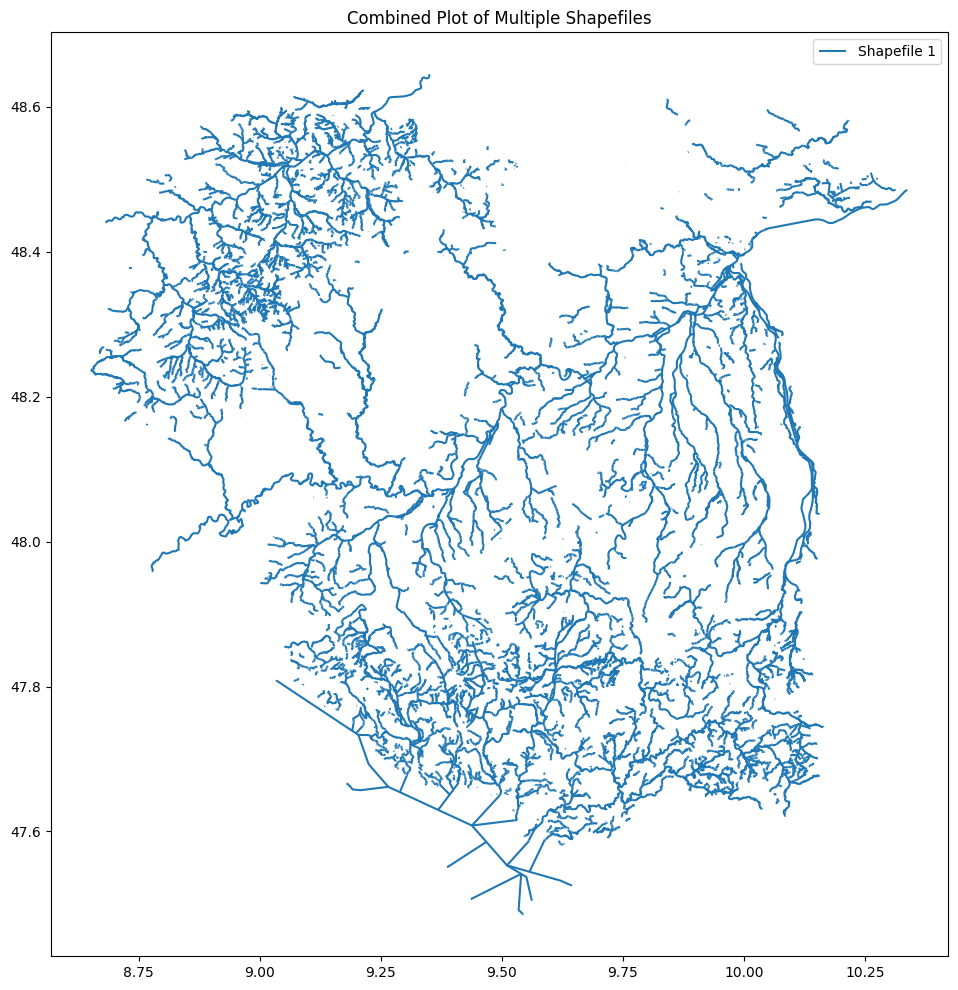

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_waterways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_5419/38635465.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


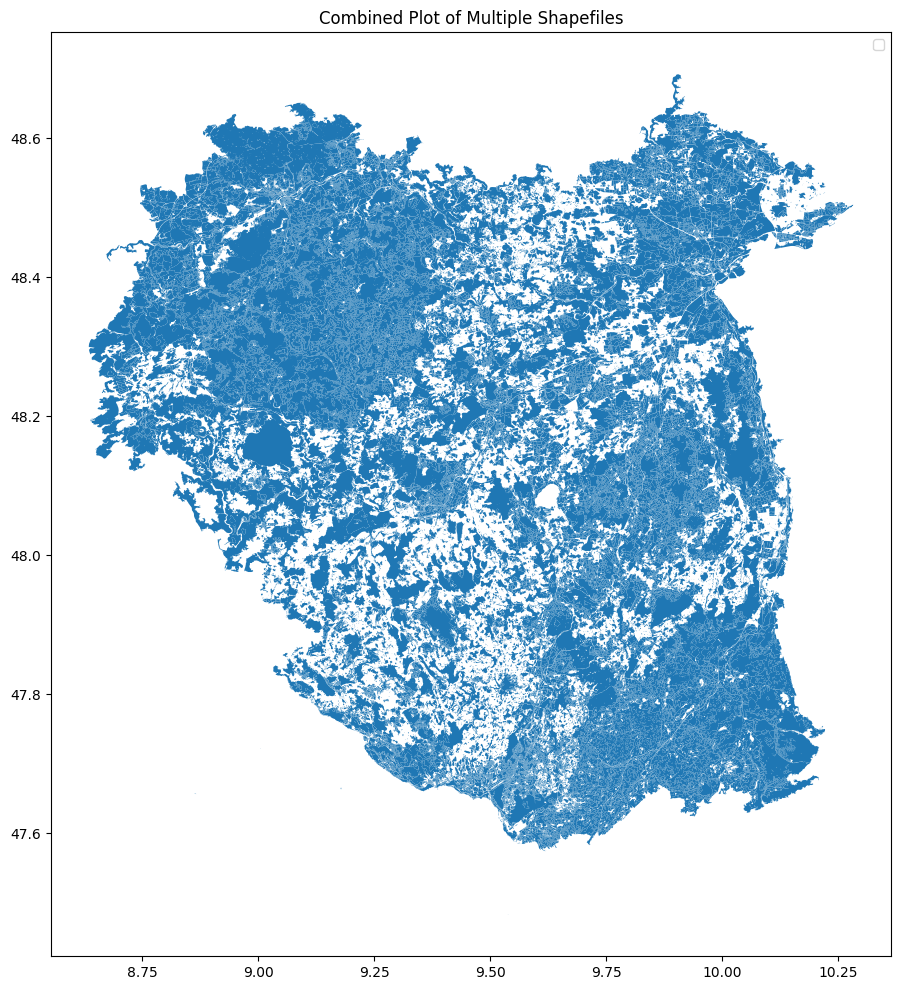

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_landuse_a_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


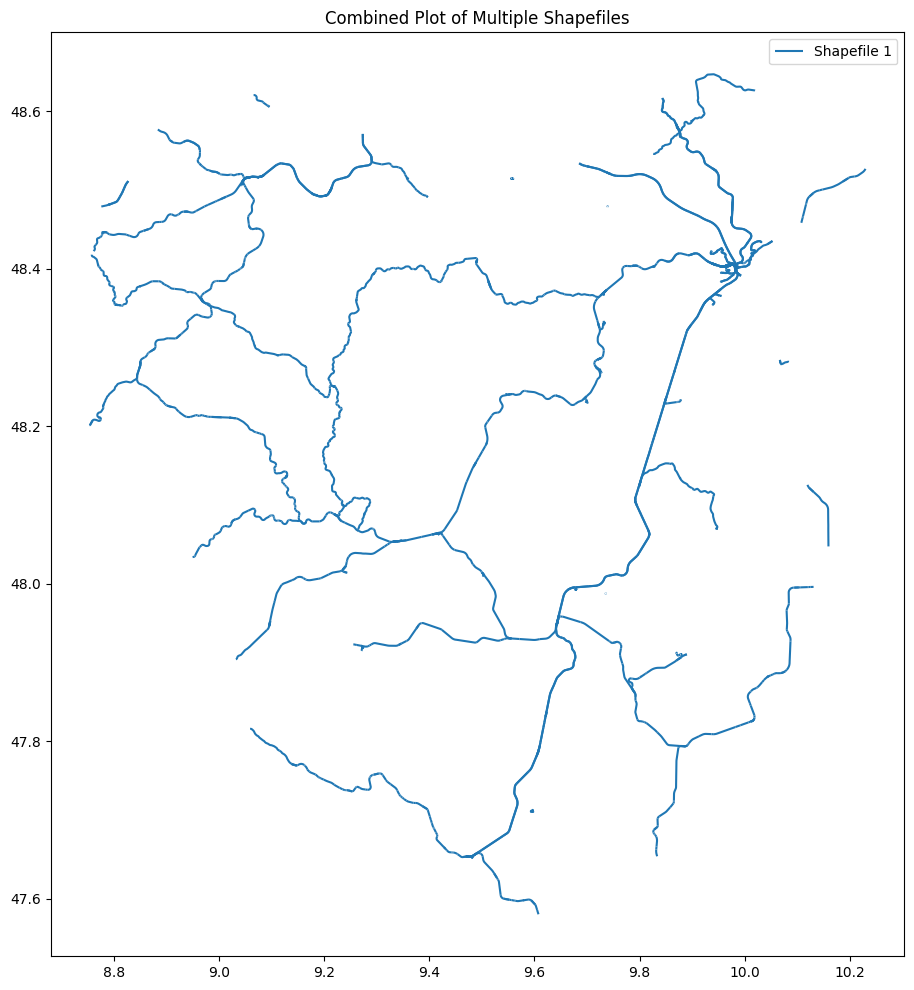

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_railways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()
